In [159]:
# this notebook I was trying to understand the fsim hamiltonian
# I couldn't make sense of the parameter g, so I think I have to make sense


import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%matplotlib widget

import sys
sys.path.append("../../../")
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import CirculatorSNAILGate, ConversionGainSmushGate
from src.cost_function import BasicCostInverse, BasicCost, BasicReducedCost
from src.optimizer import TemplateOptimizer
import h5py

In [160]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import ConversionGainSmushGate, FSimHamiltonianGate
gate_lambda = lambda g : FSimHamiltonianGate(g, -208E-3, t=12)
basis = CircuitTemplateV2(n_qubits=2, base_gates = [gate_lambda], edge_params=[[(0,1)]], no_exterior_1q=True)
basis.spanning_range = range(1,2)
# basis.build(1)
# basis.circuit.draw('mpl')

from src.sampler import HaarSample, GateSample
from src.utils.custom_gates import FSim
sampler = GateSample(gate = FSim(1*np.pi/2, 1*np.pi/6))
s = [s for s in sampler][0]

from src.optimizer import TemplateOptimizer
from src.cost_function import BasicCost, ContinuousUnitaryCostFunction
objective1 = ContinuousUnitaryCostFunction(timesteps = 100)
objective2 = BasicCost()
optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=True, override_fail=True, success_threshold = 1e-7, training_restarts=25)

In [161]:
# from qiskit.circuit.library import iSwapGate, CZGate
# def fsim(theta, phi):
#     gate = iSwapGate().power(-2 * theta/np.pi).to_matrix()
#     gate2 = CZGate().power(-phi/np.pi).to_matrix()
#     gate = np.matmul(gate, gate2)
#     return UnitaryGate(gate)
# from src.utils.visualize import unitary_to_weyl
# unitary_to_weyl(fsim(1*np.pi/2, 1*np.pi/6))
# c1c2c3(fsim(1*np.pi/2, 1*np.pi/6).to_matrix())

In [162]:
ret = optimizer3.approximate_target_U(s)

INFO:root:Begin search: (0.5, 0.5, 0.08333333)
INFO:root:Starting opt on template size 1
100%|██████████| 25/25 [05:57<00:00, 14.32s/it]
INFO:root:Cycle (k =1), Best Loss=0.5883444963475386
INFO:root:Overall Best Loss=0.5883444963475386
INFO:root:Fail: (0.5, 0.5, 0.08333333), Found: (0.48873609, 0.48873609, 0.08358908)


Cost: 0.0


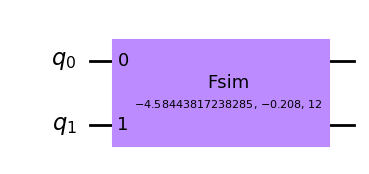

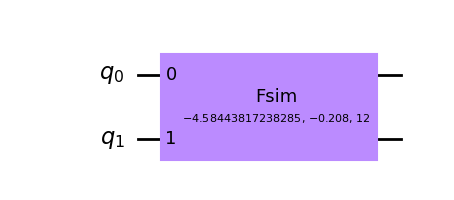

In [163]:
basis.reconstruct(ret).draw('mpl')

100%|██████████| 101/101 [00:01<00:00, 51.05it/s]


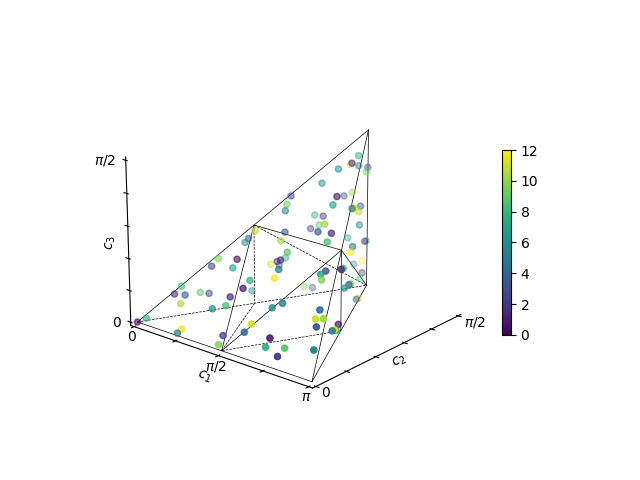

In [169]:
coordinate_list = []
from src.utils.custom_gates import FSim, BerkeleyGate, CanonicalGate
from src.hamiltonian import FSimHamiltonian
from weylchamber import c1c2c3
from qiskit.quantum_info import Operator
from src.utils.visualize import coordinate_2dlist_weyl
from qiskit.extensions import UnitaryGate
from tqdm import tqdm
coordinate_list = []
r = np.linspace(0,12,101)
for t in tqdm(r):
    qc2 = QuantumCircuit(2)
    #add fsim as a function of time
    #qc2.append(FSim(1*np.pi/2, 1*np.pi/6).power(t), [0,1])
    qc2.append(UnitaryGate(FSimHamiltonian.construct_U(ret.Xk[0], -208E-3, t=t)), [0,1])
    #eliminating x-axis symmetry
    c = list(c1c2c3(Operator(qc2).data))
    # if c[0] > 0.5:
    #     c[0] = -1*c[0] + 1
    coordinate_list.append(c)
coordinate_2dlist_weyl(coordinate_list, c=r, cmap='viridis');